# How much are top merchants spending per order? Are we retaining these top buyers?

To accomplish in this notebook- 
- Define "Top buyer" - They come every month? They have spent the most money? They spend a certain amount every month?
- Recommend definition of "top buyers" 

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
baskets = pd.read_csv('new_baskets_full.csv')
baskets['datetime'] = baskets['placed_at'].apply(lambda x: datetime.fromisoformat(x))

#pandas.Series.dt is an interface on a pandas series that gives you convenient access to operations on data stored as a pandas datetime. 
baskets['date'] = baskets['datetime'].dt.date
baskets['year'] = baskets['datetime'].dt.year
baskets['month'] = baskets['datetime'].dt.month
baskets['day'] = baskets['datetime'].dt.day
baskets['hour'] = baskets['datetime'].dt.hour
baskets['weekday'] = baskets['datetime'].dt.weekday

behaviors and reasons to incentivise top buyers, look at future behavior, look into loyalty index. What are the hallmarks of top purchaers? How can we encourage more? How can we encourage the ones we have?

#### Start by finding top buyers in terms of total amount spent.

In [54]:
baskets['spent'] = baskets['price'] * baskets['qty']

In [55]:
baskets.describe()

,id,order_id,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,year,month,day,hour,weekday,spent
count,336472.000000,336472.000000,336472.000000,336472.000000,336461.000000,336461.000000,3.364720e+05,3.364720e+05,336472.000000,336472.000000,336472.000000,336472.000000,336472.000000,3.364720e+05
mean,168236.500000,29079.405656,798.592706,525.308685,10.319098,45.395065,3.789684e+01,1.378956e+05,2021.539941,6.659588,15.970758,12.702486,2.620928,5.346555e+05
std,97131.244225,18909.738357,550.271799,304.262943,7.906257,27.767388,1.035873e+04,1.744689e+05,0.498403,3.932984,8.796420,4.228485,1.831302,2.859301e+06
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,4.375000e-02,2021.000000,1.000000,1.000000,0.000000,0.000000,5.000000e+00
25%,84118.750000,11485.000000,352.000000,322.000000,4.000000,27.000000,1.000000e+00,4.600000e+04,2021.000000,3.000000,8.000000,10.000000,1.000000,1.165000e+05
50%,168236.500000,28436.000000,664.000000,438.000000,8.000000,43.000000,2.000000e+00,1.070000e+05,2022.000000,7.000000,16.000000,12.000000,3.000000,2.080000e+05
75%,252354.250000,46193.250000,1217.000000,589.000000,14.000000,69.000000,5.000000e+00,1.845000e+05,2022.000000,11.000000,24.000000,15.000000,4.000000,4.350000e+05
max,336472.000000,62048.000000,2138.000000,1617.000000,33.000000,96.000000,4.800000e+06,5.875000e+07,2022.000000,12.000000,31.000000,23.000000,6.000000,3.831222e+08


Remove first 5 months of data from dataframe.

In [56]:
baskets.date.min()

datetime.date(2021, 4, 9)

In [57]:
baskets = baskets[baskets['date'] > pd.to_datetime('2021-7-31').date()]

In [58]:
baskets.date.min()

datetime.date(2021, 8, 1)

Find total amount spent by each merchant and sort highest to lowest.

In [59]:
baskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
664     3.947079e+09
441     1.729729e+09
366     1.724671e+09
122     1.491349e+09
430     1.441119e+09
            ...     
1158    3.575000e+05
1931    3.450000e+05
2018    3.290000e+05
411     3.190000e+05
1157    2.459000e+05
Name: spent, Length: 2128, dtype: float64

Notice that the top 5 most spending merchants are 664,441,366,122,430. Lets plot their spending over time to see if they are consistent spenders.

In [60]:
baskets['month_order'] = ((baskets['year']-2021)*12) + baskets['month'] -7

Created month_order to reindex data to start at end of july

In [61]:
baskets.sample(10)

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent,month_order
194912,195705,34605,2022-02-03 09:54:31.177,394,438,3.0,70.0,20,218500.0,2022-02-03 09:54:31.177,2022-02-03,2022,2,3,9,3,4370000.0,7
291455,291535,53299,2022-05-19 19:40:41.708,532,1016,14.0,48.0,5,18500.0,2022-05-19 19:40:41.708,2022-05-19,2022,5,19,19,3,92500.0,10
204964,205249,36708,2022-02-09 19:01:07.320,1811,1192,11.0,79.0,2,170000.0,2022-02-09 19:01:07.320,2022-02-09,2022,2,9,19,2,340000.0,7
306641,306763,55733,2022-06-17 16:39:35.867,516,840,14.0,83.0,10,92000.0,2022-06-17 16:39:35.867,2022-06-17,2022,6,17,16,4,920000.0,11
311762,312006,55136,2022-06-26 21:31:34.387,33,562,4.0,21.0,5,86000.0,2022-06-26 21:31:34.387,2022-06-26,2022,6,26,21,6,430000.0,11
203590,202703,36043,2022-02-08 22:38:15.552,384,1120,31.0,48.0,3,117500.0,2022-02-08 22:38:15.552,2022-02-08,2022,2,8,22,1,352500.0,7
105779,105931,15959,2021-11-24 11:55:32.237,637,980,11.0,96.0,1,88000.0,2021-11-24 11:55:32.237,2021-11-24,2021,11,24,11,2,88000.0,4
122956,123054,19294,2021-12-04 17:25:08.250,150,513,3.0,91.0,5,108000.0,2021-12-04 17:25:08.250,2021-12-04,2021,12,4,17,5,540000.0,5
320245,320478,58802,2022-07-13 11:59:55.954,1257,253,4.0,19.0,4,35000.0,2022-07-13 11:59:55.954,2022-07-13,2022,7,13,11,2,140000.0,12
248225,248417,44781,2022-03-18 17:47:58.458,204,778,8.0,79.0,1,72500.0,2022-03-18 17:47:58.458,2022-03-18,2022,3,18,17,4,72500.0,8


Created options to parse through top 5 spenders

In [62]:
options = [441,366,122,430, 305]

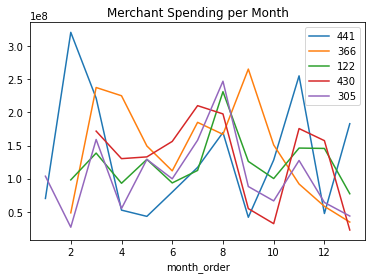

In [63]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot(title = 'Merchant Spending per Month').legend([441,366,122,430, 305],fancybox = True)


## Let's compare spending in the last 6 months. Will the same buyers be in the list?

In [64]:
sixbaskets = baskets[baskets['month_order'] > 6]

In [65]:
sixbaskets.head()

,id,order_id,placed_at,merchant_id,sku_id,top_cat_id,sub_cat_id,qty,price,datetime,date,year,month,day,hour,weekday,spent,month_order
191588,191782,33178,2022-02-01 04:59:15.772,1425,378,8.0,43.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,7
191589,191783,33178,2022-02-01 04:59:15.772,1425,380,8.0,43.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,7
191590,191784,33178,2022-02-01 04:59:15.772,1425,383,8.0,43.0,1,100500.0,2022-02-01 04:59:15.772,2022-02-01,2022,2,1,4,1,100500.0,7
191591,191749,33923,2022-02-01 06:53:29.594,1702,511,3.0,91.0,1,104000.0,2022-02-01 06:53:29.594,2022-02-01,2022,2,1,6,1,104000.0,7
191592,191750,33923,2022-02-01 06:53:29.594,1702,522,3.0,94.0,10,176000.0,2022-02-01 06:53:29.594,2022-02-01,2022,2,1,6,1,1760000.0,7


In [66]:
sixbaskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
497     959077900.0
366     952641100.0
441     941911050.0
122     938894750.0
2084    932772739.0
           ...     
484        137500.0
195        123000.0
643         99500.0
706         62000.0
1435        53500.0
Name: spent, Length: 1729, dtype: float64

Top spenders are merchant_id's 497,366,441,122,2048.

441,366,122,430,305 were the top spenders over the year, it seems that 497 and 2048 have spent a lot more in the second half, while 430 and 305 have not sustained their high spending as much in the second half. 

Found that 2084 is an outlier, don't know where code went but need to drop.

In [67]:
sixbaskets = sixbaskets.drop((sixbaskets[sixbaskets['merchant_id']==2084]).index)

In [68]:
sixbaskets.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
497     959077900.0
366     952641100.0
441     941911050.0
122     938894750.0
430     850189675.0
           ...     
484        137500.0
195        123000.0
643         99500.0
706         62000.0
1435        53500.0
Name: spent, Length: 1728, dtype: float64

In [69]:
options = [497,366,441,122,430]

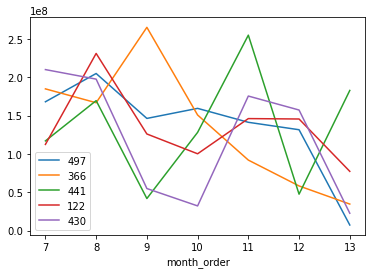

In [70]:
for i in range(5):
    sixbaskets[sixbaskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([497,366,441,122,430],fancybox = True)


Looks like all sales are declining in July of 2022 besides 441. Why is this? 441 seems to have a regular pattern of large orders every two months. They are consistent, which is valuable. There are not any outliers, so let's look at the sales from 430 and 305 in the second half to see if they are still top buyers. 

Looking at this new graph, I see no outliers, everyone is still purchasing now semi-consitently.
For the monetary score, I am going to use the data from the whole year. This is because changes in the last 6 months may be more relevant to the frequency score. 
Top 5 are: 
1. 441 (5)
2. 366 (4)
3. 122 (3)
4. 430 (2)
5. 305 (1)

RFM- recency, frequency, monetary. 
Find matrix to rank buyers by all three. 
R+F+M = Score. 
Recency is not as relevant

## Next, I am going to work on frequency: The angle I will take to rank frequency is whoever has the highest number of orders.

for each merchant, total their orders per month.


In [71]:
baskets.groupby(['merchant_id']).order_id.nunique().sort_values(ascending = False)

merchant_id
664    3918
414     497
366     315
470     284
29      279
       ... 
47        1
114       1
42        1
95        1
37        1
Name: order_id, Length: 2128, dtype: int64

<AxesSubplot:xlabel='merchant_id'>

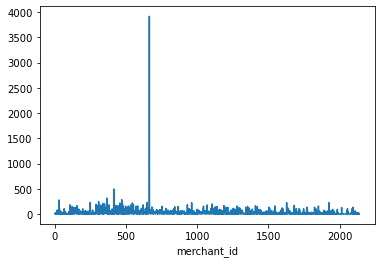

In [72]:
baskets.groupby(['merchant_id']).order_id.nunique().plot()

Plot to show how many purchases each merchant has made over the year. Notice how much 414 stands out. They are far and away the most frequent purchaser. 

Top orderers are 
1. 414 (5)
2. 366 (4)
3. 470 (3)
4. 29  (2) 
5. 308 (1)

Let's look at their order habits over time.

In [73]:
options = [414,366,470,29,308]

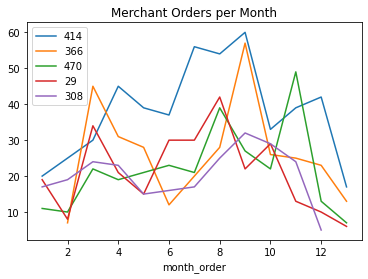

In [74]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['order_id'].nunique().plot(title = 'Merchant Orders per Month').legend([414,366,470,29,308],fancybox = True)


It looks like all merchants have consistently made orders over the year, following a generally consistent pattern. I notice that the orders drop a bit at the end- is this because of a holiday? or covid rising again over the summer?

Lets plot what their spending habits are.

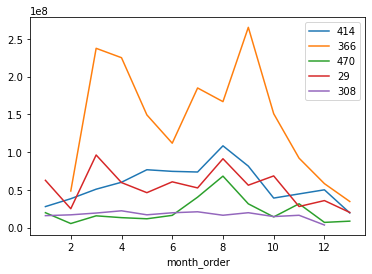

In [75]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([414,366,470,29,308],fancybox = True)


366 is spending quit a bit over the year. This makes sense because they were also on the list for top spenders.

I wonder how many items they are buying? Are their orders large or small?

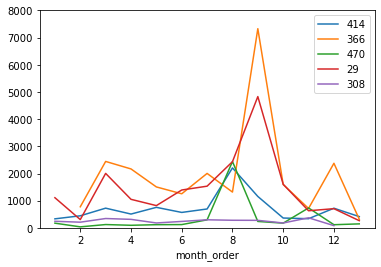

In [76]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['qty'].sum().plot(ylim = (0, 8000)).legend([414,366,470,29,308],fancybox = True)


All of the merchants spiked in their items purchased in March through april. Their spending also spiked during this time. I predicted that this would not happen because of the Ramadon holiday. Maybe they are buying more because people want to not go far from home to shop so corner stores have large stock?

### I've been noticing that a lot of the significant statistics are with merchants with low merchant id's compared to the median. Could this be becuase they assign merchant id's in the order in which they start buying? This would make sense because higher merchant id's wouldnt have the same amount of time to biuld up profiles that would spend a lot of money. In another year, some of the bigger merchants may be in the 1-2 thousands. Let's test just the last month for frequency and overall spending to see if there are higher merchant id's in the running, which would support my hypothesis. 

In [77]:
onemonth = baskets[baskets['month_order'] > 12]

In [78]:
onemonth.groupby('merchant_id').spent.sum().sort_values(ascending = False)

merchant_id
441     182885500.0
122      77248250.0
1780     70122500.0
1770     55285500.0
2095     49160500.0
           ...     
1450       417500.0
864        360000.0
460        189400.0
1711       172000.0
964         40000.0
Name: spent, Length: 271, dtype: float64

In [79]:
onemonth.groupby(['merchant_id']).order_id.nunique().sort_values(ascending = False)

merchant_id
2095    29
1924    26
1681    20
1889    19
249     19
        ..
1377     1
1291     1
1284     1
1262     1
1357     1
Name: order_id, Length: 271, dtype: int64

As I predicted, there has been a sharp rise of higher merchant id order numbers in the last month. Many merchants with ids in the thousands have broken into the top 5 both for spending and for frequency. This doesn't affect our overall findings, but note this caveat in the poster. Our top spenders now will probably not continue forever with the new merchants spending a lot. 

Now, returning to the RFM ranking, my results are:
1. 366 (8)
2. 414 (5)
3. 441 (5)
4. 470 (3)
5. 122 (3)

I gave prefferential treatment to top spenders rather than frequent purchasers, since to a for-profit business, money spent is the ultimate measure.

I think a better way to estimate the value of a customer to the company would be some statistics for a specific merchant over thier time as a customer. I am going to make a merchant table to try to do this. 

In [80]:
merchants = baskets.groupby(['merchant_id']).agg({'spent': 'sum', 'order_id': 'nunique', 'date': 'nunique', 'sku_id':'nunique', 'top_cat_id':'nunique', 'sub_cat_id':'nunique'}).reset_index()

In [81]:
merchants.sample(10)

,merchant_id,spent,order_id,date,sku_id,top_cat_id,sub_cat_id
323,333,150851500.0,6,6,17,7,12
342,352,29835650.0,32,27,92,20,37
687,698,118975000.0,10,8,43,10,20
600,611,61082650.0,60,47,135,18,36
47,50,191535550.0,14,13,256,24,57
1740,1751,3538500.0,2,2,14,4,4
1635,1646,81609150.0,72,60,117,16,33
1146,1157,245900.0,2,2,4,2,4
727,738,53869500.0,15,13,20,9,13
553,564,168061950.0,9,6,70,15,31


How can we use this to find the top merchants over time? I want to find their total spending and divide it over the time they've been a customer. lets make a new dataframe to better prepare for this.

In [82]:
dfmerch = baskets.groupby(['merchant_id']).agg({'spent': 'sum', 'month_order': 'min', 'order_id':'nunique'}).reset_index()

In [83]:
dfmerch.sample(10)

,merchant_id,spent,month_order,order_id
1348,1359,1606000.0,8,3
219,228,9162500.0,4,3
1153,1164,26860500.0,3,15
6,8,43408000.0,4,24
565,576,172455950.0,1,35
1091,1102,11415846.0,3,10
1341,1352,1454500.0,4,6
150,159,142811500.0,3,26
1987,1998,4873200.0,8,2
1993,2004,16900464.0,8,2


Now lets use this to make a row that shows the months that they've been a customer.

In [84]:
dfmerch['loyalty'] = 14 - dfmerch['month_order']

In [85]:
dfmerch.sample(10)

,merchant_id,spent,month_order,order_id,loyalty
864,875,36787000.0,3,11,11
877,888,12665000.0,3,16,11
1658,1669,89275550.0,6,18,8
1026,1037,66488500.0,3,15,11
58,61,2225100.0,3,3,11
359,369,276337000.0,3,19,11
964,975,50329850.0,3,63,11
318,328,42358000.0,3,22,11
840,851,30805300.0,3,29,11
888,899,19103000.0,3,30,11


Now we can use this data to rank merchants in terms of money spent over the months they've been a customer.

In [86]:
dfmerch['avgspent'] = dfmerch['spent'] / dfmerch['loyalty']

In [87]:
dfmerch.sample(10)

,merchant_id,spent,month_order,order_id,loyalty,avgspent
875,886,31432700.0,3,18,11,2.857518e+06
263,272,219165350.0,1,40,13,1.685887e+07
348,358,112566049.0,2,108,12,9.380504e+06
974,985,1852500.0,3,2,11,1.684091e+05
814,825,15267500.0,2,8,12,1.272292e+06
1987,1998,4873200.0,8,2,6,8.122000e+05
126,135,178317520.0,3,59,11,1.621068e+07
723,734,109917200.0,2,58,12,9.159767e+06
1712,1723,392500.0,7,2,7,5.607143e+04
191,200,6293700.0,3,8,11,5.721545e+05


In [88]:
dfmerch.sort_values(by = 'avgspent', ascending = False).head(10)

,merchant_id,spent,month_order,order_id,loyalty,avgspent
653,664,3.947079e+09,2,3918,12,3.289233e+08
2073,2084,9.327727e+08,9,3,5,1.865545e+08
10,12,4.872730e+08,11,6,3,1.624243e+08
356,366,1.724671e+09,2,315,12,1.437226e+08
430,441,1.729729e+09,1,157,13,1.330561e+08
419,430,1.441119e+09,3,159,11,1.310108e+08
113,122,1.491349e+09,2,149,12,1.242791e+08
295,305,1.368091e+09,1,126,13,1.052377e+08
30,32,1.213518e+09,2,125,12,1.011265e+08
638,649,1.078626e+09,3,231,11,9.805689e+07


This is interesting- we have new contenders at the top. Looking back, the top 3 are outliers that have been identified in the past. let's drop all three.

In [89]:
dfmerch = dfmerch.drop((dfmerch[dfmerch['merchant_id']==664]).index)
dfmerch = dfmerch.drop((dfmerch[dfmerch['merchant_id']==2084]).index)
dfmerch = dfmerch.drop((dfmerch[dfmerch['merchant_id']==12]).index)

In [90]:
dfmerch.sort_values(by = 'avgspent', ascending = False).head(10)

,merchant_id,spent,month_order,order_id,loyalty,avgspent
356,366,1.724671e+09,2,315,12,1.437226e+08
430,441,1.729729e+09,1,157,13,1.330561e+08
419,430,1.441119e+09,3,159,11,1.310108e+08
113,122,1.491349e+09,2,149,12,1.242791e+08
295,305,1.368091e+09,1,126,13,1.052377e+08
30,32,1.213518e+09,2,125,12,1.011265e+08
638,649,1.078626e+09,3,231,11,9.805689e+07
312,322,1.266263e+09,1,179,13,9.740484e+07
486,497,1.239717e+09,1,157,13,9.536284e+07
2084,2095,3.539850e+08,10,136,4,8.849625e+07


Now we can see that if we are not including how long a merchant has been a customer that we have a new top 5 spenders. 

They are:
1. 366
2. 441
3. 430
4. 122
5. 305

Re-run top 5.

In [91]:
options = [366, 441, 430, 122, 305]

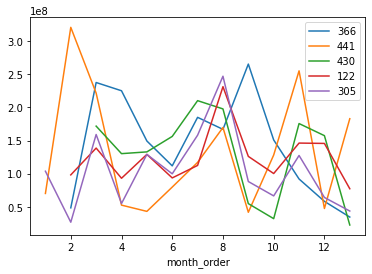

In [92]:
for i in range(5):
    baskets[baskets['merchant_id']==options[i]].groupby('month_order')['spent'].sum().plot().legend([366, 441, 430, 122, 305],fancybox = True)

Each merchant in this plot looks like they are not outliers. The top five for this method are:
1. 366
2. 441
3. 430
4. 122
5. 305

These two models for finding the top 5 reconcile pretty well with each other. 3/5 of the top 5 match, and 366 is the top customer in both. I feel that the second model represents a more fair analysis because all of the customers seem to have been loyal for a long time, so we are not ignoring new customers. These top 5 are the biggest spenders over all time, but also over each month they've purchased from us on average. 

<AxesSubplot:xlabel='loyalty'>

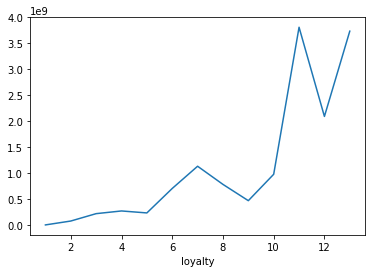

In [93]:
dfmerch.groupby(by ='loyalty')['avgspent'].sum().plot()

Wow- from how this graph looks, the customers that have been with us longer clearly spend more per month. This could be because there are more of them- let's try to filter this variable out.

How can I remove factor of merchants per loyalty month? Take average spending of all merchants over each month and plot.

In [94]:
dfmerch.groupby(by ='loyalty')['merchant_id'].nunique()

loyalty
1       3
2      18
3      22
4      25
5      44
6     167
7     225
8     157
9     120
10    243
11    651
12    232
13    218
Name: merchant_id, dtype: int64

In [95]:
df1 = dfmerch.groupby(by ='loyalty').sum().avgspent

In [96]:
df2 = dfmerch.groupby(by ='loyalty').nunique().merchant_id

In [97]:
df1/df2

loyalty
1     2.618000e+06
2     4.595447e+06
3     1.021592e+07
4     1.106171e+07
5     5.422363e+06
6     4.248987e+06
7     5.054014e+06
8     5.017685e+06
9     3.953830e+06
10    4.043968e+06
11    5.856158e+06
12    9.033538e+06
13    1.714170e+07
dtype: float64

<AxesSubplot:xlabel='loyalty'>

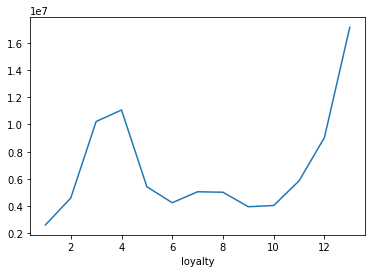

In [98]:
(df1/df2).plot()

This plot is extrememly interesting- it seems to be saying that customers that have been with us from 2-6 months, and 10-12 months are spending a majority of the money. What is going on with these in-between spenders? The drop off for 1 month makes sense, since in the most recent month, we only have 15 days of data. 

Further questions: Look into spending habits of our 6-10 month customers. Which loyalty categories do our top 5 fall into? Most likely on the higher end since they are bigger overall spenders. 

<AxesSubplot:xlabel='month_order'>

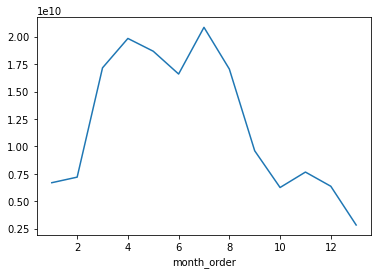

In [99]:
baskets.groupby('month_order').spent.sum().plot()

336, 441, 122. Top three merchants over both models. 

Clustering tests on merchants dataframe: dfmerch

In [102]:
def find_elbow(df, colnames, clusters_range):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    inertias = [] # wcss: Within Cluster Sum of Squares
    for k in clusters_range:
        kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
        inertias.append(kmeans.inertia_)
    plt.figure()
    plt.plot(clusters_range,inertias, marker='o')
    plt.title('Elbow method for deciding on k')
    plt.xlabel('Number of clusters: k')
    plt.ylabel('inertia')
    plt.show()
    return

In [103]:
colnames = dfmerch.columns[2:]
clusters_range = [3,4,5,6,7,8,9,10,11,12,13,14,15]
find_elbow(dfmerch, colnames,clusters_range)

NameError: name 'StandardScaler' is not defined

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score

def run_kmeans(df, colnames, k):
    df_for_cluster = df.loc[:,colnames]
    stscaler = StandardScaler().fit(df_for_cluster)
    normalized_df = stscaler.transform(df_for_cluster)

    kmeans = KMeans(init='k-means++',n_clusters=k,n_init=100, max_iter=300, random_state=0).fit(normalized_df)
    df['cluster'] = kmeans.labels_
    return df

colnames = dfmerch.columns[2:]
k = 6
merchants_kmeans = run_kmeans(dfmerch, colnames,k)
merchants_kmeans.groupby("cluster").size()


In [ ]:
merchants_kmeans[merchants_kmeans.cluster == 3]

In [ ]:
sns.pairplot(data=merchants_kmeans, hue="cluster", palette="Set1")

The RFM is a commonly used industry model, while clustering is a striactly data science practice. The support of my top five from both models shows a strong case for those top 5. A way to find future top merchants is to run both models and find consistencies between clustering and RFM model. Talk about importance of monetary- which parts predicted the best? Use data to make assesments rather than intuition- RFM has lots of assumptions- dies it have science behind it. Quote clustering reference. Business can use clustering in the future, knowing that RFM supports it, look at other merchants in this cluster as valuable according to this notebook.

Regression model?

#### [y, x1, x2, x3] -> average spent, spent in first month, spent in last month, total spent.

In [ ]:
x = dfmerch.loc[:,['spent','order_id']]
y = dfmerch.loc[:,['avgspent']]

In [ ]:
xtrain = x[500:]
xtest = x[:500]
ytrain = y[500:]
ytest = y[:500]

In [ ]:
lin_r = linear_model.LinearRegression()

In [ ]:
lin_r.fit(xtrain, ytrain)

In [ ]:
avg_pred = lin_r.predict(xtest)

In [ ]:
print("Coefficients: \n", lin_r.coef_)

In [ ]:
print("Mean squared error %.2f" % mean_squared_error(ytest, avg_pred))

In [ ]:
print("Coefficient of determination: %.2f" % r2_score(ytest, avg_pred))

In [ ]:
plt.scatter(xtest['spent'], ytest, color = "black")
plt.plot(xtest['spent'], avg_pred, color = "blue")

This regression seems to be a generally good fit for the data. How to include in poster? How to tie into overall question? That taking top merchants we can predict average spending based on total spending?